In [1]:
import numpy as np
import pylab as plt
import swyft
swyft.set_verbosity(0)
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda'

## Torus model

In [3]:
def model(params, center = np.array([0.6, 0.8])):
    a, b, c = params['a'], params['b'], params['c']
    r = ((a-center[0])**2+(b-center[1])**2)**0.5  # Return radial distance from center
    x = np.array([a, r, c])
    return dict(x=x)

def noise(obs, params, noise = np.array([0.03, 0.005, 0.2])):
    x = obs['x']
    n = np.random.randn(*x.shape)*noise
    return dict(x = x + n)

In [4]:
par0 = dict(a=0.57, b=0.8, c=1.0)
obs0 = model(par0)  # Using Asimov data

In [80]:
prior = swyft.Prior({"a": ["uniform", 0., 1.], "b": ["uniform",  0., 1.], "c": ["uniform", 0., 1.]})

In [104]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000, Nmax = 15000)
s.run(train_args = dict(lr_schedule = [1e-3, 1e-4, 1e-5]), max_rounds = 10, keep_history = True)

NRE round: R = 1
Number of training samples is N_R = 3000
Additional simulations are required after growing the cache.
Simulate: 100%|██████████| 3015/3015 [00:05<00:00, 602.04it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 2.518
validation loss = 2.296
validation loss = 2.289
validation loss = 2.181
validation loss = 2.282
lr: 0.0001
validation loss = 2.2
validation loss = 2.135
validation loss = 2.206
lr: 1e-05
validation loss = 2.189
validation loss = 2.109
validation loss = 2.215
Train losses: [3.060442634991237, 2.3961607019106546, 2.2647420437563035, 2.2447562430586134, 2.1387378530842915, 2.1047123840876987, 2.0984509800161635, 2.082517923343749]
Valid losses: [2.518122249179416, 2.296342796749539, 2.28861485587226, 2.18116119172838, 2.199990749359131, 2.1346271302964954, 2.1890451510747275, 2.108834226926168]
Finished trainloop.
constr_prior_R : prior_R volume = 0.1015 : 1
NRE round: R = 2
Number of training samples is N_R = 3000
Additiona

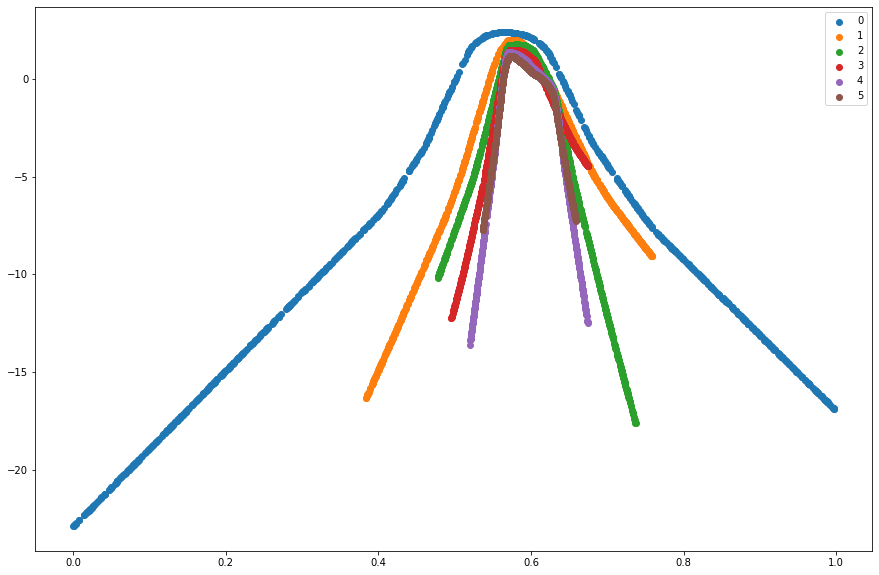

In [118]:
plt.figure(figsize = (15, 10))
N = len(s._history)
for i in range(N):
    params = s._history[i]['marginals']._prior.sample(1000)
    r = s._history[i]['marginals']._re.lnL(s._obs, params)[('a',)]
    rmax = r.max()
    plt.scatter(params['a'], r, label = str(i))
plt.legend()

In [119]:
s2 = []
for Ninit in [1000, 3000, 10000, 30000]:
    st = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = Ninit, Nmax = 15000)
    st.run(train_args = dict(lr_schedule = [1e-3, 1e-4, 1e-5]), max_rounds = 1, keep_history = True)
    s2.append(st)

NRE round: R = 1
Number of training samples is N_R = 1000
Additional simulations are required after growing the cache.
Simulate: 100%|██████████| 1022/1022 [00:01<00:00, 577.05it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 3.386
validation loss = 2.889
validation loss = 2.627
validation loss = 2.643
lr: 0.0001
validation loss = 2.476
validation loss = 2.449
validation loss = 2.512
lr: 1e-05
validation loss = 2.556
validation loss = 2.583
Train losses: [3.9416951877730235, 2.853490786893027, 2.504767196519034, 2.396805282149996, 2.3904188786234175, 2.3578572188104903]
Valid losses: [3.385505040486654, 2.888995409011841, 2.6268619696299234, 2.4756737550099692, 2.4491774241129556, 2.5563724835713706]
Finished trainloop.
constr_prior_R : prior_R volume = 0.353 : 1
NRE round: R = 1
Number of training samples is N_R = 3000
Additional simulations are required after growing the cache.
Simulate: 100%|██████████| 2949/2949 [00:05<00:00, 576.29it/s]
Startin

In [121]:
st = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 100000, Nmax = 15000)
st.run(train_args = dict(lr_schedule = [1e-3, 1e-4, 1e-5]), max_rounds = 1, keep_history = True)
s2.append(st)

NRE round: R = 1
Number of training samples is N_R = 100000
Additional simulations are required after growing the cache.
Simulate: 100%|██████████| 99736/99736 [02:26<00:00, 679.53it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 2.058
validation loss = 2.03
validation loss = 2.023
validation loss = 2.027
lr: 0.0001
validation loss = 1.986
validation loss = 1.979
validation loss = 1.985
lr: 1e-05
validation loss = 1.961
validation loss = 1.985
Train losses: [2.1417959302079446, 2.0489730489020253, 2.0291476546336837, 1.9740235973806943, 1.9687478286059783, 1.9629046215305566]
Valid losses: [2.057873093046943, 2.0298107870138726, 2.023310186011998, 1.9858350332143606, 1.9790617453706993, 1.9612307192045009]
Finished trainloop.
constr_prior_R : prior_R volume = 0.03286 : 1


(-20.0, 5.0)

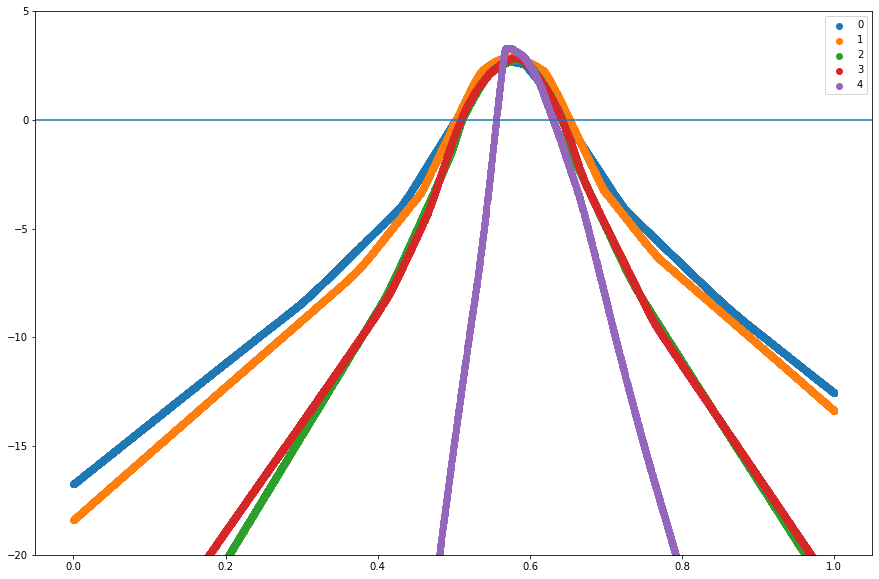

In [134]:
plt.figure(figsize = (15, 10))
for i in range(5):
    params = s2[i]._history[0]['marginals']._prior.sample(10000)
    r = s2[i]._history[0]['marginals']._re.lnL(s._obs, params)[('a',)]
    rmax = r.max()
    plt.scatter(params['a'], r, label = str(i))
plt.axhline(0)
plt.legend()
plt.ylim([-20, 5])

(-20.0, 5.0)

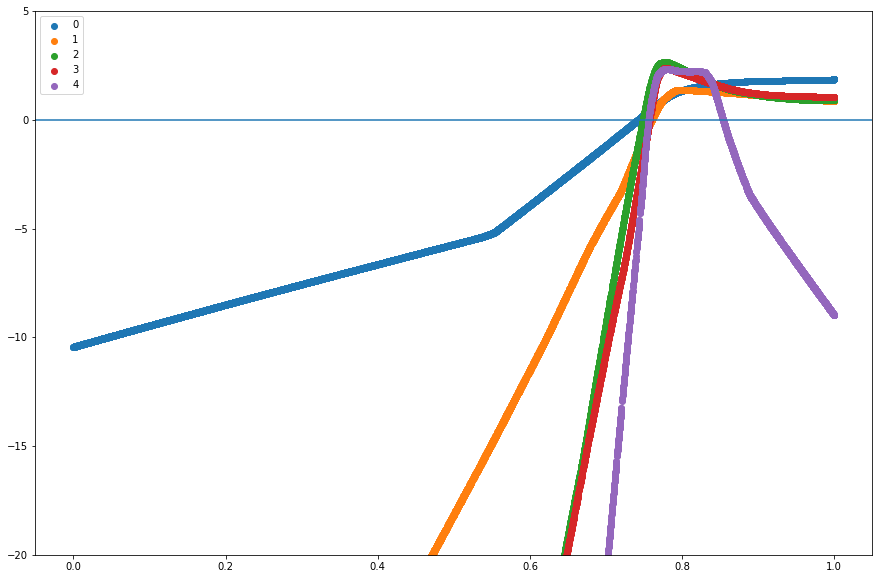

In [135]:
plt.figure(figsize = (15, 10))
for i in range(5):
    params = s2[i]._history[0]['marginals']._prior.sample(10000)
    r = s2[i]._history[0]['marginals']._re.lnL(s._obs, params)[('b',)]
    rmax = r.max()
    plt.scatter(params['b'], r, label = str(i))
plt.axhline(0)
plt.legend()
plt.ylim([-20, 5])

(-10.0, 3.0)

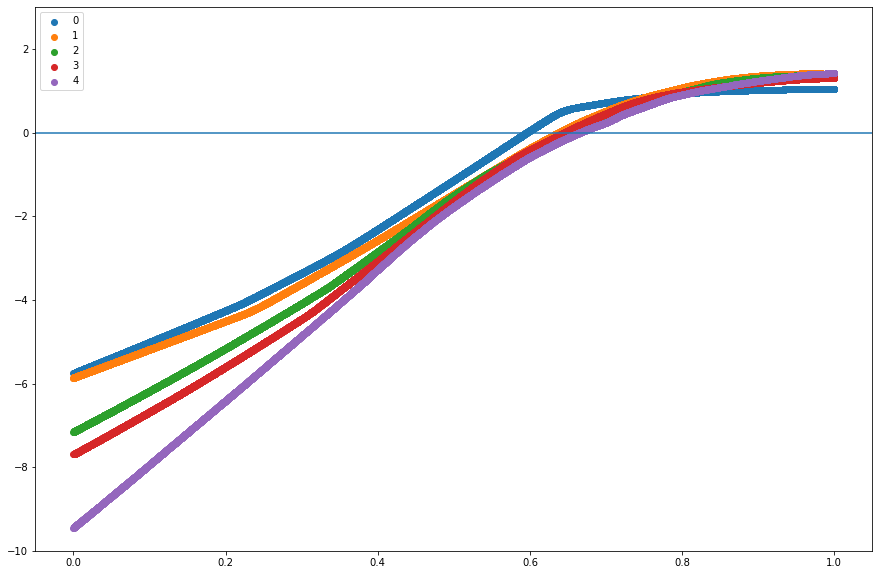

In [137]:
plt.figure(figsize = (15, 10))
for i in range(5):
    params = s2[i]._history[0]['marginals']._prior.sample(10000)
    r = s2[i]._history[0]['marginals']._re.lnL(s._obs, params)[('c',)]
    rmax = r.max()
    plt.scatter(params['c'], r, label = str(i))
plt.axhline(0)
plt.legend()
plt.ylim([-10, 3])